# Bibliotecas

In [ ]:
# Instale as bibliotecas necessárias (execute apenas uma vez, se ainda não instaladas)

!pip install google-api-python-client networkx matplotlib youtube_transcript_api
!pip install youtube-transcript-api
!pip install transformers torch
!pip install sentence-transformers
!pip install wordcloud matplotlib
!pip install nltk
#!pip install tensorflow
!pip install --upgrade tensorflow
#!pip install --upgrade pysentimiento #upgrade pysentimiento to the latest version
!pip install pysentimiento
!pip install --upgrade transformers
!pip install powerlaw

In [ ]:
# Importações dos módulos necessários ao longo do programa
import csv
from googleapiclient.discovery import build
from youtube_transcript_api import YouTubeTranscriptApi
from youtube_transcript_api._errors import TranscriptsDisabled, NoTranscriptFound
import itertools
import networkx as nx
import matplotlib.pyplot as plt
from transformers import BertTokenizer, BertModel
import torch
from googleapiclient.errors import HttpError
from sklearn.metrics.pairwise import cosine_similarity
from itertools import cycle
import os
from sentence_transformers import SentenceTransformer
import datetime
from datetime import datetime
from wordcloud import WordCloud
from pysentimiento import create_analyzer
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from collections import Counter
from math import ceil
import pandas as pd
import numpy as np

# Chaves API

In [ ]:
# Substitua pelas suas chaves de API do YouTube
API_KEYS = []

In [ ]:
def testaChaveAPI(chave_api):
    try:
        youtube = build("youtube", "v3", developerKey=chave_api)
        resposta = youtube.search().list(
            q="test",
            part="id",
            maxResults=1
        ).execute()
        print(f"Chave {chave_api} está funcionando!")
    except HttpError as e:
        if e.resp.status == 403 and "quotaExceeded" in str(e):
            print(f"Cota excedida para a chave {chave_api}.")
        else:
            print(f"Erro com a chave {chave_api}: {e}")

for chave in API_KEYS:
    testaChaveAPI(chave)

In [ ]:
#Troca chaves se uma tem cota excedida durante extração de dados
def trocaChave(chaves_api):
    """
    Obtém o serviço do YouTube alternando entre chaves de API para lidar com cotas excedidas.
    """
    if not chaves_api:
        raise ValueError("A lista de chaves API está vazia!")

    chaves_usadas = set()
    ciclo_chavesAPI = cycle(chaves_api)  # Ciclo para alternar as chaves

    while True:
        chaveAtual = next(ciclo_chavesAPI)  # Pega a próxima chave do ciclo

        if chaveAtual in chaves_usadas:
            continue  # Se já foi testada, ignora e tenta a próxima

        try:
            youtube = build("youtube", "v3", developerKey=chaveAtual)
            # Testa a chave com uma busca simples
            youtube.search().list(q="test", part="id", maxResults=1).execute()
            print(f"Usando chave válida: {chaveAtual}")
            return youtube, chaveAtual
        except HttpError as e:
            if e.resp.status == 403 and "quotaExceeded" in str(e):
                print(f"Cota excedida para a chave {chaveAtual}. Ignorando...")
            elif e.resp.status == 400 and "keyInvalid" in str(e):
                print(f"Chave inválida: {chaveAtual}. Ignorando...")
            else:
                print(f"Erro inesperado com a chave {chaveAtual}: {e}")
            chaves_usadas.add(chaveAtual)

    raise RuntimeError("Todas as chaves API estão inválidas ou excederam a cota.")


# BERT

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')
def get_bert_embedding(text):
    # Tokenizar o texto
    inputs = tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=512)

    # Obter embeddings do modelo BERT
    with torch.no_grad():
        outputs = model(**inputs)

    # Pegar a representação do último hidden layer
    # A primeira posição [0] é a [CLS] token (representação do texto)
    embedding = outputs.last_hidden_state.mean(dim=1)  # Média das representações para simplificar

    return embedding

In [ ]:
def get_bert_embedding(text):
    # Tokenizar o texto
    inputs = tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=512)

    # Obter embeddings do modelo BERT
    with torch.no_grad():
        outputs = model(**inputs)

    # Pegar a representação do último hidden layer
    # A primeira posição [0] é a [CLS] token (representação do texto)
    embedding = outputs.last_hidden_state.mean(dim=1)  # Média das representações para simplificar

    return embedding

In [ ]:

def compute_similarity(text1, text2):
    embedding1 = get_bert_embedding(text1)
    embedding2 = get_bert_embedding(text2)

    # Calcular a similaridade entre os embeddings
    similarity = cosine_similarity(embedding1, embedding2)
    return similarity[0][0]  # Retorna o valor de similaridade

## Coleta de Dados

In [ ]:
def youtubeBERT(chavesAPI, query, max_results=500, saida_csv="youtube_results.csv", dataInicio=None, dataFim=None):
    """
    Realiza busca no YouTube, processa transcrições e encontra vídeos relacionados usando BERT.
    """
    ciclosChaveAPI = itertools.cycle(chavesAPI)  # Ciclo para alternar as chaves
    youtube, chaveAtual = trocaChave(ciclosChaveAPI)

    qtdMaxReqs = 50
    total = 0
    resultados = []
    videosColetados = set()  # Conjunto para evitar vídeos duplicados
    next_page_token = None
    arestas = []
    titulos = {}
    metadadosVideos = {}

    transcription_file = "transcriptions.txt"  # Arquivo consolidado de transcrições

    # Inicialização do BERT para similaridade
    model = SentenceTransformer("all-MiniLM-L6-v2")
    embeddings = {}

    with open(transcription_file, "w", encoding="utf-8") as tf:
        while total < max_results:
            remaining_results = min(max_results - total, qtdMaxReqs)

            try:
                search_response = youtube.search().list(
                    q=query,
                    part="id,snippet",
                    type="video",
                    maxResults=remaining_results,
                    pageToken=next_page_token,
                    publishedAfter=dataInicio.isoformat() + "Z" if dataInicio else None,
                    publishedBefore=dataFim.isoformat() + "Z" if dataFim else None
                ).execute()

            except HttpError as e:
                if e.resp.status == 403 and "quotaExceeded" in str(e):
                    print(f"Cota excedida para a chave {chaveAtual}. Tentando próxima chave.")
                    youtube, chaveAtual = trocaChave(ciclosChaveAPI)
                    continue
                else:
                    print(f"Erro inesperado com a chave {chaveAtual}: {e}")
                    raise

            for item in search_response.get("items", []):
                video_id = item["id"]["videoId"]
                video_url = f"https://www.youtube.com/watch?v={video_id}"

                # Evitar duplicação
                if video_url in videosColetados:
                    continue

                title = item["snippet"]["title"]
                channel_title = item["snippet"]["channelTitle"]
                published_at = item["snippet"]["publishedAt"].split("T")[0]  # Extrai apenas a parte da data (YYYY-MM-DD)

                # Validar intervalo de tempo (após chamada da API)
                video_date = datetime.strptime(published_at, "%Y-%m-%d")
                if (dataInicio and video_date < dataInicio) or (dataFim and video_date > dataFim):
                    continue

                titulos[video_url] = title
                videosColetados.add(video_url)  # Marcar como processado

                try:
                    transcript = YouTubeTranscriptApi.get_transcript(video_id, languages=["pt"])
                    transcript_text = " ".join([entry['text'] for entry in transcript])
                except (TranscriptsDisabled, Exception):
                    transcript_text = "Transcrição não disponível"

                # Salvar transcrição consolidada no arquivo
                tf.write(f"{title}: {transcript_text}\n\n")

                # Criar embedding para similaridade
                embeddings[video_url] = model.encode(f"{title} {transcript_text}")

                # Detalhes do vídeo
                video_details_response = youtube.videos().list(
                    part="statistics",
                    id=video_id
                ).execute()

                statistics = video_details_response.get("items", [])[0].get("statistics", {})
                like_count = statistics.get("likeCount", "N/A")
                comment_count = statistics.get("commentCount", "N/A")
                view_count = statistics.get("viewCount", "N/A")

                metadadosVideos[video_url] = {
                    "likes": int(like_count) if like_count != "N/A" else 0,
                    "comments": int(comment_count) if comment_count != "N/A" else 0,
                    "views": int(view_count) if view_count != "N/A" else 0
                }

                resultados.append({
                    "title": title,
                    "channel": channel_title,
                    "url": video_url,
                    "type": "Principal",
                    "linked_to": "",
                    "transcription": transcription_file,
                    "likes": like_count,
                    "comments": comment_count,
                     "views": view_count,
                    "published_at": published_at
                })

            total += len(search_response.get("items", []))
            next_page_token = search_response.get("nextPageToken")
            if not next_page_token:
                break

    # Identificar conexões entre vídeos
    video_urls = list(embeddings.keys())
    for i, url1 in enumerate(video_urls):
        for j, url2 in enumerate(video_urls):
            if i != j:
                similarity = cosine_similarity([embeddings[url1]], [embeddings[url2]])[0][0]
                if similarity > 0.75:  # Threshold para conexões relevantes
                    arestas.append((url1, url2))
                    resultados[i]["linked_to"] += f"{titulos[url2]} // "

    # Salvar resultados em CSV
    with open(saida_csv, mode="w", newline="", encoding="utf-8") as csv_file:
        writer = csv.DictWriter(csv_file, fieldnames=["title", "channel", "url", "type", "linked_to", "transcription", "likes", "comments", "views", "published_at"],
                                quoting=csv.QUOTE_ALL)
        writer.writeheader()
        writer.writerows(resultados)


    print(f"Dados salvos no arquivo: {saida_csv}")
    print(f"Transcrições salvas no arquivo: {transcription_file}")
    return resultados, arestas, titulos, metadadosVideos


## Análise de Sentimentos:

### Sentimento com 200 palavras e normalização

In [ ]:
from collections import Counter
from math import ceil
import csv

def analisarSentimentos200_palavras(entrada_txt, saida_txt):
    """
    Analisa o sentimento de transcrições extraídas de um arquivo TXT a cada 200 palavras.

    Args:
        entrada_txt (str): Caminho para o arquivo de entrada no formato TXT.
        saida_txt (str): Caminho para salvar os resultados da análise em CSV.
    """
    # Inicializa o analisador de sentimentos
    analisador = create_analyzer(task="sentiment", lang="pt")

    # Leitura do arquivo TXT
    with open(entrada_txt, "r", encoding="utf-8") as file:
        linhas = file.readlines()

    resultados = []
    for l in linhas:
        # Ignorar linhas vazias ou mal formatadas
        if not l.strip() or ": " not in l:
            continue

        # Separar título e transcrição pelo último ': '
        titulo, transcricao = l.strip().rsplit(": ", 1)

        titulo = titulo.strip()
        transcricao = transcricao.strip()

        palavras = transcricao.split()
        tamBloco = 200
        contadorSentimentos = Counter({"POS": 0, "NEG": 0, "NEU": 0})

        # Processar a transcrição em blocos de 200 palavras
        qtdBlocos = ceil(len(palavras) / tamBloco)
        for i in range(qtdBlocos):
            inicio = i * tamBloco
            final = min(inicio + tamBloco, len(palavras))
            bloco = " ".join(palavras[inicio:final])

            if bloco:
                sentimento = analisador.predict(bloco)
                contadorSentimentos[sentimento.output] += 1

        # Normalizar os resultados
        total_blocos = sum(contadorSentimentos.values())
        resultadosNormalizados = {key: round(count / total_blocos, 4) for key, count in contadorSentimentos.items()}

        # Adicionar resultados à lista
        resultados.append({
            "title": titulo,
            "positive": resultadosNormalizados.get("POS", 0),
            "negative": resultadosNormalizados.get("NEG", 0),
            "neutral": resultadosNormalizados.get("NEU", 0),
            "predominante": max(resultadosNormalizados, key=resultadosNormalizados.get)
        })

    # Verificar se há resultados
    if not resultados:
        print("Nenhuma transcrição válida foi encontrada no arquivo.")
        return

    # Salvar resultados em CSV
    with open(saida_txt, "w", newline="", encoding="utf-8") as csv_file:
        writer = csv.DictWriter(csv_file, fieldnames=["title", "positive", "negative", "neutral", "predominante"], quoting=csv.QUOTE_ALL)
        writer.writeheader()
        writer.writerows(resultados)

    print(f"Resultados salvos em: {saida_txt}")

## Visualização:

### Nuvem de Palavras:

In [ ]:
def remove_stopwords(texto, language='portuguese', nossasStopWords=None):
    """Remove stopwords de um texto."""
    stop_words = set(stopwords.words(language))

    if nossasStopWords:
        stop_words.update(nossasStopWords)

    words = texto.split()
    palavrasFiltradas = [palavra for palavra in words if palavra.lower() not in stop_words]
    return " ".join(palavrasFiltradas)

def nuvemCorYT(word, font_size, position, orientation, random_state=None, **kwargs):
    """Define cores inspiradas no esquema de cores do YouTube."""
    tonsVermelhos = ["#FF0000", "#D32F2F", "#B71C1C"]  # Tons de vermelho
    tonsPretoBranco = ["#000000", "#FFFFFF"]  # Preto e branco
    return random_state.choice(tonsVermelhos + tonsPretoBranco)

def gerarNuvem(txt_file, nossasStopWords=None):
    """Gera a nuvem de palavras a partir do arquivo de transcrição."""
    try:
        with open(txt_file, 'r', encoding='utf-8') as file:
            texto = file.read()

        if not texto.strip():
            print("O arquivo de transcrição está vazio.")
            return

        # Passa a lista de nossasStopWords para a função remove_stopwords
        texto_sem_stopwords = remove_stopwords(texto, nossasStopWords=nossasStopWords)

        # Cria a nuvem de palavras
        wordcloud = WordCloud(
            width=800, height=400, background_color="gray",
            max_words=200, color_func=nuvemCorYT
        ).generate(texto_sem_stopwords)

        # Exibe a nuvem de palavras
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation="bilinear")
        plt.axis("off")
        plt.title("Nuvem de Palavras (Transcrição)")
        plt.show()

    except FileNotFoundError:
        print(f"Arquivo '{txt_file}' não encontrado.")
    except Exception as e:
        print(f"Erro ao gerar a nuvem de palavras: {e}")


# Main:

In [ ]:
# Receber inputs do usuário
consulta = input("Digite a string de busca: ")
qtdMaxResultados = int(input("Quantos resultados você deseja (máximo 500)? "))
inicioColeta = input("Digite a data de início (YYYY-MM-DD) ou deixe vazio: ")
fimColeta = input("Digite a data de término (YYYY-MM-DD) ou deixe vazio: ")

inicio = datetime.strptime(inicioColeta, "%Y-%m-%d") if inicioColeta else None
fim = datetime.strptime(fimColeta, "%Y-%m-%d") if fimColeta else None

saida_csv = input("Digite o nome do arquivo de saída (ex: resultados.csv): ")
sentimento200_csv = input("Digite o nome do arquivo de saída da análise de sentimentos(ex: senti.csv): ")

palavrasRetiradas = ['eh', 'é', 'tipo', 'ah', 'tá', 'gente', 'porque', 'nada', 'cara', 'tô', 'então', 'ver',
                'deve', 'sabe', 'fica', 'tão', 'pro', 'pra', 'portanto', 'isso', 'aqui', 'né',
                'assim', 'ainda', 'ali', 'disso', 'aí', 'quê', 'que', 'sei','inclusive', 'vai', 'vão',
                'coisa','muito','muita', 'menos', 'dar', 'se', 'galera', 'tava', 'lá', 'ó', 'pô', 'ai',
                'dá', 'mim', 'talvez', 'desse', 'vez', 'acha', 'deixa', 'sendo', 'vem', 'bem', 'deu',
                'tanto', 'vamos', 'fazendo', 'vi', 'diz','nessa', 'daí', 'acho', 'onde',
                'durante', 'pega', 'pode', 'fazer', 'faz', 'fez', 'enfim', 'falei', 'falou',
                'dizendo', 'acontece', 'acontecendo', 'aconteceu', 'cada', 'ter', 'tem', 'tendo',
                'olha', 'algo', 'alguém', 'vou', 'tudo', 'todo', 'sempre', 'outro', 'outra', 'outros',
                 'outras', 'coisa', 'coisas', 'precisa', 'precisar', 'precisou', 'alguma', 'algum',
                  'alguns', 'disse', 'dizer', 'entendeu', 'entender', 'tal', 'nada', 'paí', 'quanto',
                    'quantos', 'quantas', 'falar', 'queria', 'falando', 'ninguém', 'vê', 'querem',
                     'chegar', 'quero', 'ia', 'ficar', 'dessa', 'desse', 'dessas', 'desses',
                     'deste', 'desta', 'destes', 'destas', 'acontecer','nunca','nenhum', 'quer',
                     'desde', 'conta', 'existe', 'sobre', 'tempo', 'antes', 'depois', 'justamente',
                     'texto', 'parte', 'nesse', 'nesses', 'nessas', 'neste', 'nestes',
                     'nesta', 'nestas', 'nisto', 'isto', 'esse', 'esses','essas','essa', 'aquele', 'aqueles',
                     'aquelas','aquela','aquilo', 'ir', 'quiser', 'texto', 'agora', 'vídeo', 'trabalha',
                     'meio','qualquer', 'toda', 'todas', 'todos', 'realmente', 'trabalhando',
                     'mano', 'fala', 'exatamente', 'exemplo', 'veja', 'primeiro', 'segundo',
                     'pegar', 'maneira', 'n', 'mê', 'principalmente', 'simplesmente', 'forma',
                     'posso', 'ligado', 'cima', 'deixar', 'parece', 'tema', 'deveria', 'passar',
                     'trazer', 'canal', 'lugar', 'vendo', 'jeito', 'mesma', 'mesmo', 'paraa', 'dentro',
                     'caras', 'cara', 'ficou','muito','muitos','muita','muitas', 'amigo','partir', 'continuar',
                     'continua', 'continuou','parece','pessoa','pessoas', 'Paulo','poderia','enquanto','cabeça',
                     'vezes','posso','apenas','começa','passar','começar','começou']

# Execução das funções
videos = youtubeBERT(API_KEYS, consulta, qtdMaxResultados, saida_csv, inicio, fim)
gerarNuvem("/content/transcriptions.txt", palavrasRetiradas)
analisarSentimentos200_palavras("/content/transcriptions.txt", sentimento200_csv)

# Gephi

## Arestas

In [ ]:
def generate_gephi_edges(input_csv, output_csv):
    """
    Gera uma tabela de arestas para o Gephi a partir das colunas title e linked_to.
    """
    try:
        edges = []
        title_to_id = {}

        # Ler o arquivo de entrada e mapear títulos para IDs
        with open(input_csv, 'r', encoding='utf-8') as infile:
            reader = csv.DictReader(infile)
            for i, row in enumerate(reader, start=1):
                title = row['title']
                title_to_id[title] = i  # Mapear título para ID baseado na linha

        # Reprocessar o arquivo para criar as arestas
        with open(input_csv, 'r', encoding='utf-8') as infile:
            reader = csv.DictReader(infile)
            for row in reader:
                source_title = row['title']
                linked_to = row['linked_to']

                if linked_to:
                    linked_videos = [video.strip() for video in linked_to.split('//') if video.strip()]
                    source_id = title_to_id[source_title]

                    for dest_title in linked_videos:
                        if dest_title in title_to_id:
                            target_id = title_to_id[dest_title]
                            edges.append([source_id, target_id, 'Directed'])

        # Criar o arquivo de saída no formato exigido pelo Gephi
        with open(output_csv, 'w', encoding='utf-8', newline='') as outfile:
            writer = csv.writer(outfile)
            writer.writerow(['Source', 'Target', 'Type'])
            writer.writerows(edges)
    except Exception as e:
        print(f'Erro ao processar o arquivo: {e}')


In [ ]:
generate_gephi_edges("/content/resultados.csv", "arestas.csv")

## Vértices

In [ ]:
import csv
import html

def generate_gephi_vertices(input_csv, sentiment_csv, output_csv):
    """
    Gera uma tabela de vértices para o Gephi a partir dos títulos do CSV,
    incluindo a análise de sentimento na coluna "predominante" e o engajamento.
    """
    try:
        # Ler o arquivo de sentimentos
        sentiment_data = {}
        with open(sentiment_csv, 'r', encoding='utf-8') as sent_file:
            sent_reader = csv.DictReader(sent_file)
            for row in sent_reader:
                sentiment_data[row['title'].strip()] = row['predominante'].strip()

        # Ler o arquivo de entrada principal
        video_data = {}
        with open(input_csv, 'r', encoding='utf-8') as infile:
            reader = csv.DictReader(infile)
            for row in reader:
                title = row['title'].strip()
                likes = row['likes'] if row['likes'].isdigit() else 0
                comments = row['comments'] if row['comments'].isdigit() else 0
                views = row['views'] if row['views'].isdigit() else 0
                engajamento = int(likes) + int(comments) + int(views)
                video_data[title] = engajamento

        # Criar o arquivo de saída com as colunas "predominante" e "engajamento"
        with open(output_csv, 'w', encoding='utf-8', newline='') as outfile:
            writer = csv.writer(outfile, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)

            # Escrever o cabeçalho exigido pelo Gephi com colunas adicionais
            writer.writerow(['Id', 'Label', 'Predominante', 'Engajamento'])

            # Escrever os dados dos vértices com ID, Label, Predominante e Engajamento
            for idx, (title, engajamento) in enumerate(video_data.items(), start=1):
                pred = sentiment_data.get(title, 'NEU')

                # Descodificar entidades HTML e limpar caracteres especiais
                title = html.unescape(title)  # Converte entidades HTML (como &#39; para ')

                # Garantir que a coluna 'Label' tenha o formato correto de aspas
                title = title.replace('"', '""')  # Substitui aspas por duas aspas para o CSV

                # Garantir que o título esteja corretamente escapado
                # Se o título contiver uma vírgula, ele será automaticamente colocado entre aspas
                # pelo csv.writer
                title = f'"{title}"' if ',' in title or '"' in title else title

                # Escrever a linha no arquivo de saída
                writer.writerow([idx, title, pred, engajamento])

        print(f'Tabela de vértices para Gephi gerada com sucesso em "{output_csv}"!')
    except Exception as e:
        print(f'Erro ao processar o arquivo: {e}')


In [ ]:
generate_gephi_vertices("/content/resultados.csv", "/content/senti.csv", "nos.csv")

#Itens da parte 2


In [ ]:

def load_and_analyze_edges(edges_file):
    try:
        # Leitura do arquivo com as arestas
        edges_df = pd.read_csv(edges_file)
    except Exception as e:
        print(f'Forneça uma arquivo válido: {e}')
        return

    # Eliminar duplicatas convertendo para arestas não direcionadas
    undirected_edges = set(edges_df.apply(lambda row: tuple(sorted((row['Source'], row['Target']))), axis=1))

    # Contando os graus de cada nó
    all_degrees = Counter()
    for source, target in undirected_edges:
        all_degrees[source] += 1
        all_degrees[target] += 1

    # Exibir a distribuição de graus
    print("Distribuição de Graus (Nó: Grau):")
    nos = []
    graus = []
    for node, degree in sorted(all_degrees.items()):
      nos.append(node)
      graus.append(degree)
      print(f"{node}: {degree}")

    # Obter a lista de graus para plotagem
    degrees = list(all_degrees.values())

    # Plotagem do gráfico de pontos
    plt.figure(figsize=(10, 6))
    plt.scatter(x = nos, y = graus)
    plt.xlabel('Nós')
    plt.ylabel('Grau')
    plt.title('Distribuição de Graus dos Nós')
    plt.grid(True)
    plt.xticks(np.arange(min(nos), max(nos)+1, 1))
    plt.yticks(np.arange(min(graus), max(graus)+1, 1))
    plt.show()

# Use o nome do arquivo contendo as arestas como argumento
load_and_analyze_edges('arestas.csv')


## Regressão Linear

### Importações

In [ ]:
import pandas as pd
import networkx as nx
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

### Arestas x Nós

In [ ]:
# Substitua pelos caminhos corretos dos seus arquivos CSV
arestas_csv = '/content/arestas.csv'
nos_csv = '/content/nos.csv'

# Carregar os dados
nos_df = pd.read_csv(nos_csv)
arestas_df = pd.read_csv(arestas_csv)

G = nx.Graph()

# Adiciona os nós (assumindo que a coluna 'id' identifica cada nó)
for _, row in nos_df.iterrows():
    G.add_node(row['Id'], **row.to_dict())

# Adiciona as arestas (assumindo colunas 'source' e 'target')
for _, row in arestas_df.iterrows():
    G.add_edge(row['Source'], row['Target'])

# Obter o grau de cada nó
graus = dict(G.degree())

# Adicionar o grau ao DataFrame dos nós
nos_df['grau'] = nos_df['Id'].map(graus)

# Remover valores nulos
dados = nos_df.dropna(subset=['grau', 'Engajamento'])

# Definir as variáveis para regressão
X = dados[['grau']]  # Variável independente
y = dados['Engajamento']    # Variável dependente

# Inicializar e ajustar o modelo
modelo = LinearRegression()
modelo.fit(X, y)

# Coeficiente angular e intercepto
print(f'Coeficiente angular (inclinação): {modelo.coef_[0]}')
print(f'Intercepto: {modelo.intercept_}')

Coeficiente angular (inclinação): 209.08919289357974
Intercepto: 78518.14252123502


#### Visualização

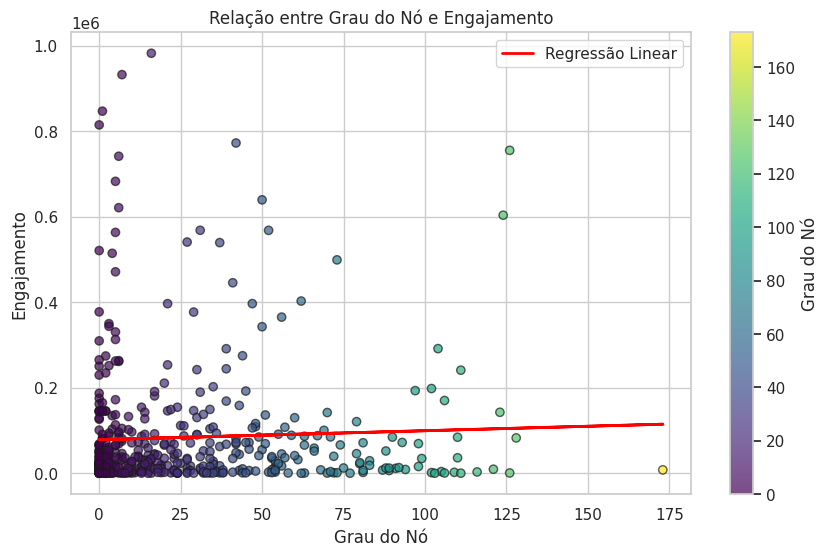

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from sklearn.linear_model import LinearRegression

# Verificar se a coluna 'grau' foi criada corretamente
if 'grau' not in nos_df.columns:
    # Calcular o grau novamente
    graus = dict(G.degree())
    nos_df['grau'] = nos_df['Id'].map(graus)

# Remover valores nulos
dados = nos_df.dropna(subset=['grau', 'Engajamento'])

# Definir as variáveis para regressão
X = dados[['grau']]
y = dados['Engajamento']

# Ajustar o modelo de regressão
modelo = LinearRegression()
modelo.fit(X, y)

# Predições
y_pred = modelo.predict(X)

# Configurações do gráfico
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))

# Gráfico de dispersão com coloração pelo grau
scatter = plt.scatter(dados['grau'], dados['Engajamento'],
                      c=dados['grau'], cmap='viridis', alpha=0.7, edgecolor='k')

# Linha de regressão
plt.plot(dados['grau'], y_pred, color='red', linewidth=2, label='Regressão Linear')

# Barra de cores para indicar o grau
cbar = plt.colorbar(scatter)
cbar.set_label('Grau do Nó')

# Rótulos e título
plt.xlabel('Grau do Nó')
plt.ylabel('Engajamento')
plt.title('Relação entre Grau do Nó e Engajamento')
plt.legend()
plt.grid(True)

# Exibir o gráfico
plt.show()


## g) Calcule a assortividade do grafo.
a. Plote o gráfico da assortividade além de apresentar o coeficiente de
Pearson.


In [ ]:
!pip install networkx
!pip install matplotlib

Saving RedeComplexa2TP.graphml to RedeComplexa2TP.graphml
Coeficiente de Assortatividade de Pearson: 0.01337980964160453


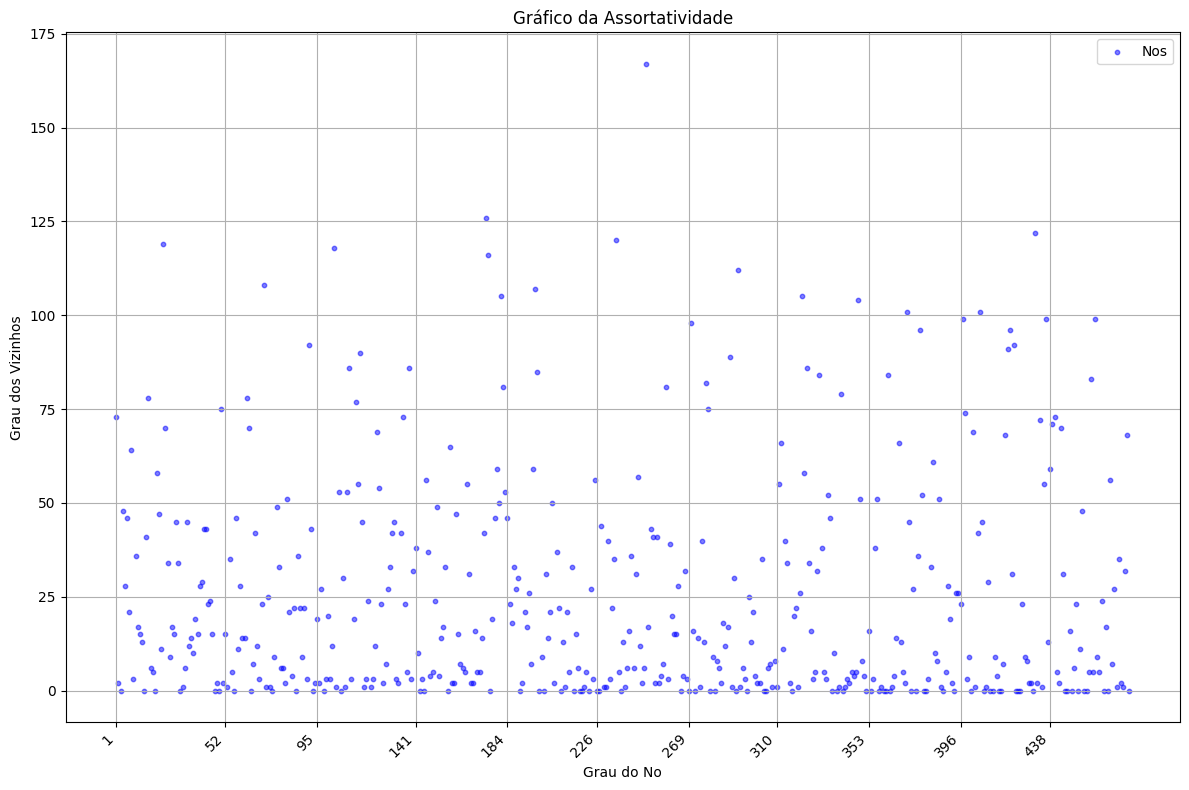

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

from google.colab import files

# Upload do arquivo .graphml
uploaded = files.upload()

# Verifica o nome do arquivo
for fn in uploaded.keys():
    caminho_arquivo = fn

G = nx.read_graphml(caminho_arquivo)

# Calculando o coeficiente de assortatividade
assortividade = nx.degree_assortativity_coefficient(G)
print(f'Coeficiente de Assortatividade de Pearson: {assortividade}')

# Criando o gráfico da assortatividade
degrees = dict(G.degree())
x, y = zip(*degrees.items())

# Agrupando por faixas de graus e pegando valores representativos
unique_degrees = sorted(set(x))
step = max(1, len(unique_degrees) // 10)
representative_degrees = unique_degrees[::step]

plt.figure(figsize=(12, 8))
plt.scatter(x, y, c='blue', s=10, alpha=0.5, label='Nos')
plt.title('Gráfico da Assortatividade')
plt.xlabel('Grau do No')
plt.ylabel('Grau dos Vizinhos')

# Ajustando os valores de referência no eixo X com faixas representativas
plt.xticks(representative_degrees, rotation=45, ha='right')

plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Saving RedeComplexa2TP.graphml to RedeComplexa2TP (5).graphml
        Distância
58315           8
58316           8
105599          8
114267          8
116630          8
116631          8
117418          8
117419          8
122143          8
122144          8
122145          8
122146          8
122147          8
142243          8


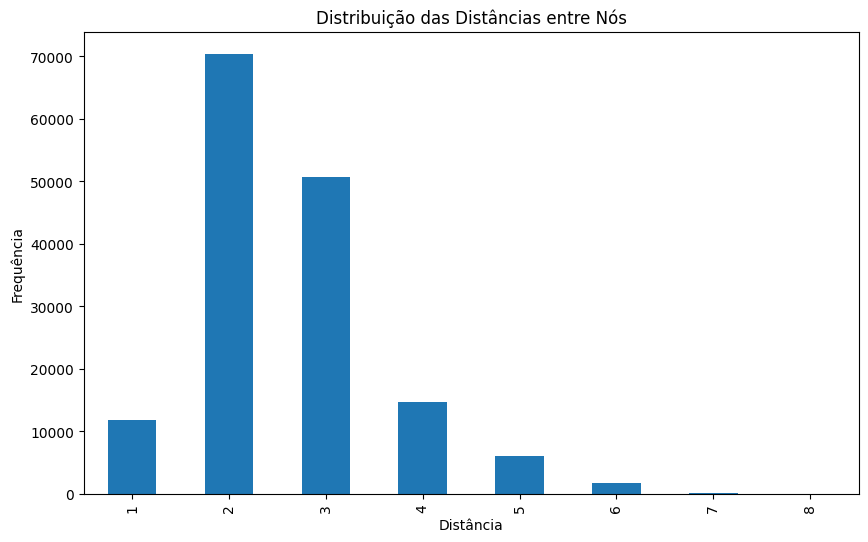

A distância média entre todos os nós é: 2.6061782015368404


In [ ]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt

# Carregar o arquivo GEXF exportado do Gephi
from google.colab import files

# Upload do arquivo .graphml
uploaded = files.upload()

# Verifica o nome do arquivo
for fn in uploaded.keys():
    caminho_arquivo = fn
G = nx.read_graphml(caminho_arquivo)


# Calcular todas as distâncias entre os nós
distancias = dict(nx.all_pairs_shortest_path_length(G))

# Criar uma lista com todas as distâncias (ignorando a distância zero para si mesmo)
distancias_lista = []
for origem, destinos in distancias.items():
    for destino, distancia in destinos.items():
        if origem != destino:
            distancias_lista.append(distancia)

# Criar um DataFrame com as distâncias
df_distancias = pd.DataFrame(distancias_lista, columns=['Distância'])
df_distancias_8 = df_distancias[df_distancias['Distância'] == 8]


# Calcular a distribuição das distâncias
distribuicao_distancias = df_distancias['Distância'].value_counts().sort_index()
# Printar todas as distâncias calculadas
print(df_distancias_8)
# Calcular a distância média
distancia_media = df_distancias['Distância'].mean()

# Plotar a distribuição das distâncias
plt.figure(figsize=(10, 6))
distribuicao_distancias.plot(kind='bar')
plt.xlabel('Distância')
plt.ylabel('Frequência')
plt.title('Distribuição das Distâncias entre Nós')
plt.show()

print(f'A distância média entre todos os nós é: {distancia_media}')


## Análise Power Law

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

# Importando a rede (assumindo um formato como GML)
G = nx.read_graphml("yt.graphml")  # Substitua pelo nome do seu arquivo

In [ ]:
degrees = [G.degree(n) for n in G.nodes()]
degree_count = np.bincount(degrees)  # Contagem de cada grau
x = np.nonzero(degree_count)[0]  # Valores únicos de grau
y = degree_count[x]  # Frequência dos graus

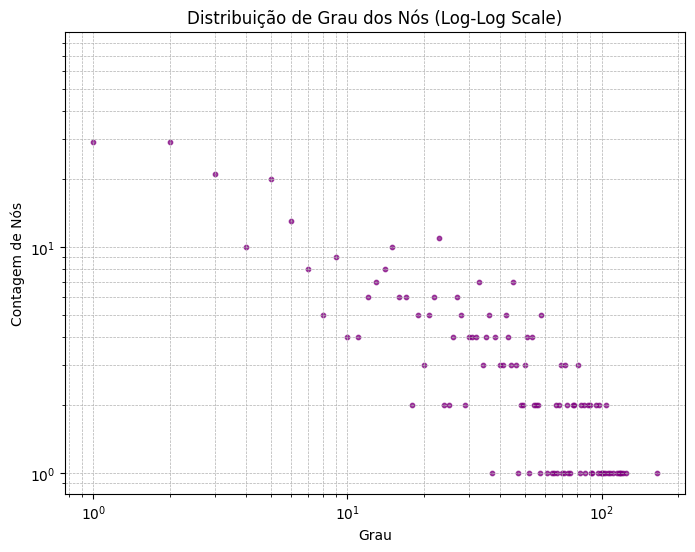

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(x, y, color='purple', alpha=0.7, s=10)  # Pontos
plt.xscale("log")
plt.yscale("log")
plt.title("Distribuição de Grau dos Nós (Log-Log Scale)")
plt.xlabel("Grau")
plt.ylabel("Contagem de Nós")
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.show()

Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit
Alpha (expoente da power law): 8.494724797808736
xmin (valor mínimo para seguir power law): 95.0
R: -0.01258731296946447, p-value: 0.9794329107318042


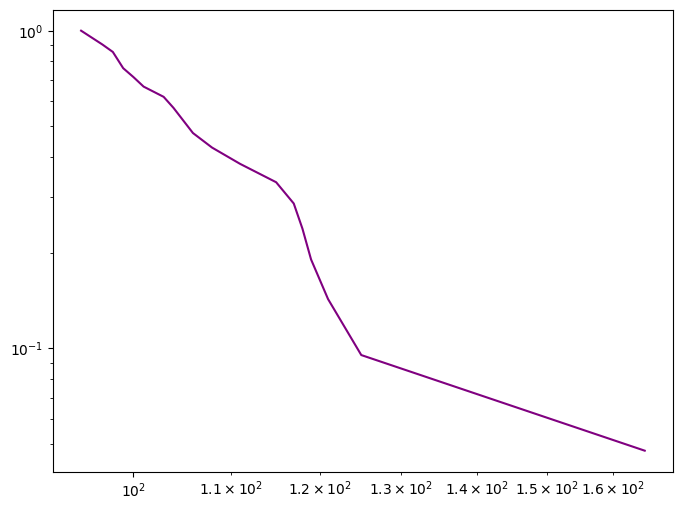

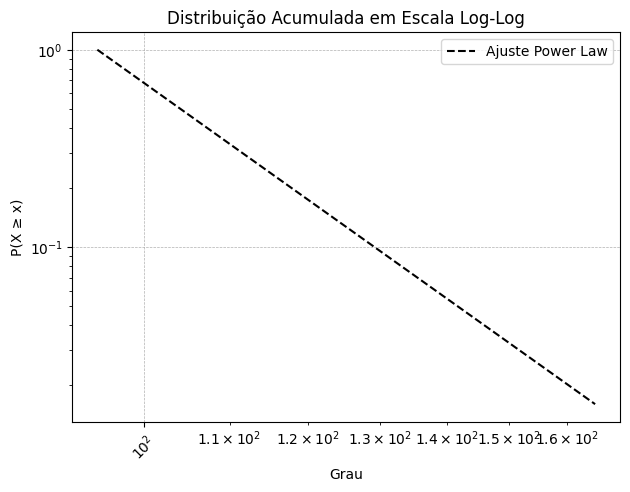

In [ ]:
import networkx as nx
import powerlaw
import matplotlib.pyplot as plt

# Carregar a rede (exemplo com arquivo GraphML)
G = nx.read_graphml("yt.graphml")  # Substitua pelo nome do seu arquivo

# Obter os graus dos nós
degrees = [G.degree(n) for n in G.nodes()]

# Ajustar uma power law usando a biblioteca powerlaw
fit = powerlaw.Fit(degrees)
alpha = fit.power_law.alpha
xmin = fit.power_law.xmin

# Exibir os resultados
print(f"Alpha (expoente da power law): {alpha}")
print(f"xmin (valor mínimo para seguir power law): {xmin}")

# Comparar com outras distribuições (ex.: exponencial)
R, p = fit.distribution_compare('power_law', 'exponential')
print(f"R: {R}, p-value: {p}")

# R > 0 favorece power law; p > 0.1 sugere que a power law não pode ser rejeitada.

# Plotar a distribuição acumulada com o ajuste da power law em um único gráfico
plt.figure(figsize=(8, 6))

# Plotar os dados empíricos
fit.plot_ccdf(label='Dados Empíricos', color='purple')

# Plotar o ajuste da power law
fit.power_law.plot_ccdf(label='Ajuste Power Law', linestyle='--', color='black')

# Ajustar as escalas dos eixos
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Grau")
plt.ylabel("P(X ≥ x)")

# Corrigir sobreposição no eixo x
plt.xticks(rotation=45)  # Rotaciona os valores do eixo x
plt.tight_layout()  # Ajusta automaticamente os elementos para evitar sobreposição

# Outros ajustes visuais
plt.legend(loc='best')  # Melhorar posição da legenda
plt.grid(True, linestyle='--', linewidth=0.5)
plt.title("Distribuição Acumulada em Escala Log-Log")
plt.show()
